In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score

import shap
import math as m
import itertools

import eli5
from eli5.sklearn import PermutationImportance

import statsmodels.api as sm

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
X = df.drop(["target", "index"], axis=1)
y = df[["target"]]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

# по 33% разделили выборку 

# Значения Шипли

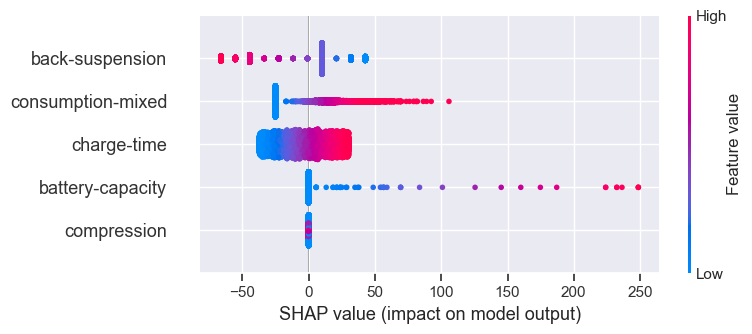

In [3]:
train_cut_X = train_X[train_X.columns[:5]]
test_cut_X = test_X[train_X.columns[:5]]

reg = LinearRegression().fit(train_cut_X, train_y)

explainer = shap.Explainer(reg, train_cut_X)
shap_values = explainer(test_cut_X)

shap.summary_plot(shap_values, test_cut_X)

In [4]:
print('Значения Шипли')

shap_values = []
for feature in train_cut_X.columns:
    
    cols = list(train_cut_X.columns)
    N = len(cols) #Весь набор факторов
    
    # Вычисляем мощность множества факторов без признака feature(обозначим как S)
    cols_wo_feature = list(train_cut_X.drop(columns=[feature]).columns)
    
    subsets_col = []
    
    for r in range(len(cols_wo_feature) + 1):
        subsets_col.extend(itertools.combinations(cols_wo_feature, r))
    
    subsets_col = [list(s) for s in subsets_col]   
    
    phi = 0 
    
    for subset in subsets_col:
        train_subset = train_cut_X[subset] if subset else np.zeros((train_cut_X.shape[0], 1))
        test_subset = test_cut_X[subset] if subset else np.zeros((test_cut_X.shape[0], 1))
    
    # Обучаем модель со всеми факторами subset
        reg = LinearRegression().fit(train_subset, train_y) 
        f_s = reg.predict(test_subset)
                                 
    # Теперь добавляем столбец признака feature и обучаем модель c ним
        train_with_feature = train_cut_X[subset + [feature]] if subset else train_cut_X[[feature]]
        test_with_feature = test_cut_X[subset + [feature]] if subset else test_cut_X[[feature]]
        
        reg = LinearRegression().fit(train_with_feature, train_y)
        f_si = reg.predict(test_with_feature)
    
        w = (m.factorial(len(subset)) * m.factorial(N - len(subset) - 1)) / m.factorial(N)
        phi += w * np.mean(f_si - f_s)
    
    shap_values.append(phi)
    print(f'{feature}: {phi}')


Значения Шипли
back-suspension: 0.46296467755391274
battery-capacity: -0.045902263665596535
charge-time: -0.10943294892770751
compression: 0.018413289552567894
consumption-mixed: 0.2307836973314415


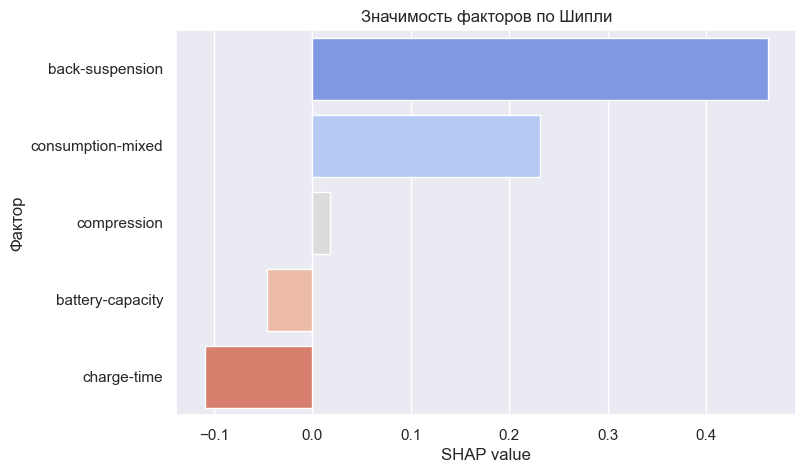

In [5]:
shap_df = pd.DataFrame({"feature": cols, "SHAP": shap_values})
shap_df = shap_df.sort_values("SHAP", ascending=False)  # Сортировка по важности

plt.figure(figsize=(8, 5))
sns.barplot(x="SHAP", y="feature", data=shap_df, palette="coolwarm")
plt.xlabel("SHAP value")
plt.ylabel("Фактор")
plt.title("Значимость факторов по Шипли")
plt.show()

# Пермутационная важность

In [6]:
reg = LinearRegression().fit(train_X, train_y)
perm = PermutationImportance(reg, random_state=42).fit(test_X, test_y)
eli5.show_weights(perm, feature_names=list(test_X.columns))

Weight,Feature
0.3617 ± 0.0044,cylinders-value
0.1035 ± 0.0039,configurations_tank-volume
0.0959 ± 0.0066,configurations_seats
0.0498 ± 0.0020,engine-type
0.0466 ± 0.0009,engine-start
0.0291 ± 0.0012,configurations_auto-premiere
0.0287 ± 0.0023,charge-time
0.0196 ± 0.0027,compression
0.0193 ± 0.0019,gear-type
0.0165 ± 0.0020,weight


In [7]:
print('Коэффициенты пермутационной важности')
for col in df.columns:
    Metrics = []
    X = df.drop(["target", "index"], axis=1) # в Х теперь попал перемешанный столбец
    y = df[["target"]]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)
    reg = LinearRegression().fit(train_X, train_y)
    r_2= reg.score(train_X, train_y)
    
    
    for i in range(100):  # 100 раз повторяем 
        np.random.shuffle(df[col].values) 
        X = df.drop(["target", "index"], axis=1) # в Х теперь попал перемешанный столбец
        y = df[["target"]]
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)
        
        reg = LinearRegression().fit(train_X, train_y)
        r2_shuffled = reg.score(train_X, train_y)
    
        Metrics.append(r_2 - r2_shuffled)
    weight = np.mean(Metrics)
    print(f'{col}:{weight}')

Коэффициенты пермутационной важности
index:0.0
back-suspension:-1.9347342049442772e-05
battery-capacity:0.003639279827094808
charge-time:1.5427203739426521e-06
compression:0.006358135816085532
consumption-mixed:0.00022772280022965164
cylinders-order:0.00041820981499127716
cylinders-value:0.1214626073857504
engine-feeding:0.0011511218769655596
engine-start:7.855669269089871e-05
engine-stop:0.00013624364354030026
engine-type:0.003449248563724624
gear-type:0.02120509176027807
luxury:0.0005286923600174853
max-speed:5.809094711628604e-05
power-electro-kw:0.00021282451725038954
supply-system:8.255557207486386e-05
valves:0.0061653296706520345
valvetrain:0.0035733413887934517
weight:0.012625742857868502
configurations_auto-premiere:0.0018084372468012055
configurations_back-wheel-base:0.010365287274254651
configurations_front-brake:0.00272455414413872
configurations_safety-rating:0.0002789099452818733
configurations_seats:0.04121725442969936
configurations_tank-volume:0.16626387760833578
superg